In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
from adjustText import adjust_text
from datetime import datetime
import sys
import os
import gseapy as gp
import matplotlib as mpl
import plotly.express as px
mpl.rcParams['pdf.fonttype'] = 42

paper_path = "/mnt/x/Common/Lab_Papers/shedding_potential/"
fig_path = paper_path + "fig4/"
utils_path = paper_path + "utils/"

pan_gi_path = "/mnt/x/talbarka/datasets/pan-gi_cell_atlas/3_Extended_Pan-GI_atlas_all_lineages_18485genes_20241119.h5ad"


os.chdir(utils_path)
print(os.getcwd())
import shed_funcs
import plot_gsea
import matplotlib.patheffects as PathEffects
import importlib
from tqdm import tqdm
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

np.random.seed(0)


LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/talbarka/fonts/arial/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

    print("scanpy " + str(sc.__version__))
    print("pandas " + str(pd.__version__))
    print("numpy " + str(np.__version__))
    print("scipy " + str(scipy.__version__))

/mnt/x/Common/Lab_Papers/shedding_potential/utils
scanpy 1.9.3
pandas 2.0.3
numpy 1.24.4
scipy 1.11.1


(278, 18924)
(278, 18924)
(278, 18742)
(278, 18742)
(247, 18742)


/tmp/ipykernel_2628328/3155403617.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.obs['sum_of_umis'] = 0


(99, 18742)
Correlation: 0.732462550185905, p-value: 0.0


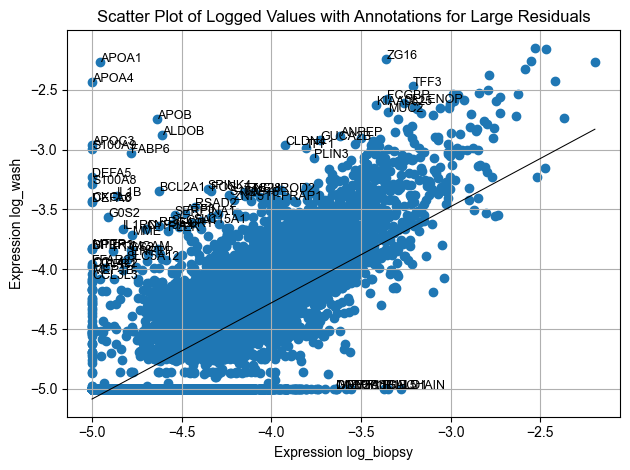

In [2]:
UMI_THRESH = 10000

t = scipy.io.loadmat(fig_path+'data_dan_paper.mat')
t = t['t']

sdata = sc.AnnData(np.array(t['seq_data'][0][0]).T)
sdata.var.index = [gene[0][0] for gene in pd.DataFrame(t['gene_name'])[0][0]]
sdata.obs.index = [pt[0][0] for pt in pd.DataFrame(t['Sample_name'])[0][0].tolist()]

field_to_add = ["Location","Patient","Disease_str","Sample_type"]
for field in field_to_add:
    sdata.obs[field] = [x[0] for x in pd.DataFrame(t[field])[0][0]]

additional_round = ['Location', 'Disease_str',"Sample_type"]
for field in additional_round:
    sdata.obs[field] = [x[0] for x in sdata.obs[field]]

sdata.obs.index.name="sample_name"
sdata.var.index.name="gene_name"
sdata.var['gene_name'] = sdata.var.index
sdata.obs.columns = sdata.obs.columns.str.lower()
sdata.obs.sample_type = sdata.obs.sample_type.str.lower()
print(sdata.shape)
sdata.obs.head()

print(sdata.shape)
specific_genes_to_remove = ["MTRNR2L12", "MTRNR2L1", "MTRNR2L8", "AURKAIP1", "GPM6A"]
filter_genes = sdata.var_names.str.startswith("MT-") + sdata.var_names.isin(specific_genes_to_remove) + sdata.var_names.str.contains("RPL") + sdata.var_names.str.contains("RPS")
sdata = sdata[:,~filter_genes]
print(sdata.shape)

# calculate sum of counts per cell
sdata.obs['sum_of_umis'] = 0
sdata.obs.sum_of_umis = np.sum(sdata.X,axis=1)

# filter samples wiht sum_of_umis < UMI_THRESH
print(sdata.shape)
sdata = sdata[sdata.obs.sum_of_umis > UMI_THRESH,:]
print(sdata.shape)

sdata.layers['counts'] = sdata.X.copy()
sdata.layers['mat_norm'] = sc.pp.normalize_total(sdata, target_sum=1, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X']
sdata.layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(sdata, target_sum=10000, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X'], copy=True)
sdata.layers['log_zscore'] = sdata.layers['log_norm'].copy()

importlib.reload(shed_funcs)
# select controls and RL colon
sdata_hc = sdata[(sdata.obs.disease_str == "control") * (sdata.obs.location.isin(["R","L"]))].copy()
print(sdata_hc.shape)

resids_hc = shed_funcs.calc_resids_by_field(sdata_hc, "sample_type", "biopsy", "wash", RESID_THRESH=1, layer='mat_norm')
resids_hc['gene_display'] = resids_hc.index

In [3]:
LOAD_ORIG = False
gi_colon_epi_control_path = fig_path +"pan_gi_colon_epithelial_control.h5ad"
if LOAD_ORIG:
    adata = sc.read(pan_gi_path)
    print(adata.shape)
    adata = adata[(adata.obs.organ_groups == "Large_intestine") * (adata.obs.disease == "control") * (adata.obs.level_1_annot == "Epithelial")]
    # create mat_norm layer
    adata.layers['mat_norm'] = sc.pp.normalize_total(adata, target_sum=1, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X']
    print(adata.shape)
    # export to h5ad
    adata.write(gi_colon_epi_control_path)
    adata
else:
    adata = sc.read(gi_colon_epi_control_path)
    adata

In [4]:
adata_orig = adata.copy()

In [5]:
adata = adata_orig.copy()

# add turnover score
print(resids_hc.shape)
intersect_genes = np.intersect1d(resids_hc.index, adata.var_names)
shedding_resids = resids_hc.loc[intersect_genes]
print(resids_hc.shape)

adata.obs['shedding_score'] = None
adata.var['shedding_residual'] = None
adata.var.loc[shedding_resids.index, 'shedding_residual']= shedding_resids['residual']

tmp_ad = adata[:,shedding_resids.index].copy()
sc.pp.normalize_total(tmp_ad, target_sum=1, exclude_highly_expressed=True, max_fraction=0.1)

print(tmp_ad.shape)

resids_vals = np.array(tmp_ad.var['shedding_residual'])
resids_vals = np.expand_dims(resids_vals, axis=1).ravel()
resids_matnorm = tmp_ad.layers['mat_norm']

shedding_scores = resids_matnorm @ resids_vals.astype(float)

tmp_ad.obs['shedding_score'] = np.squeeze(np.array(shedding_scores))
# send back the shedding score from the tmp_ad to the adata
adata.obs.loc[tmp_ad.obs.index, 'shedding_score'] = tmp_ad.obs.loc[tmp_ad.obs.index, 'shedding_score']


(18742, 6)
(18742, 6)


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


(102822, 16156)


In [6]:
genes_cutoffs = dict() # first element is the cutoff, second element is whether to take the top or bottom
genes_cutoffs['AQP8'] = (0.001, True)
genes_cutoffs['GUCA2B'] = (0.001, True)
genes_cutoffs['ZG16'] = (0.001, False)

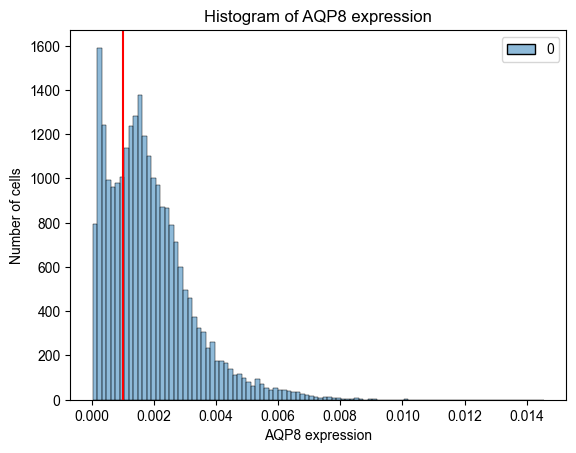

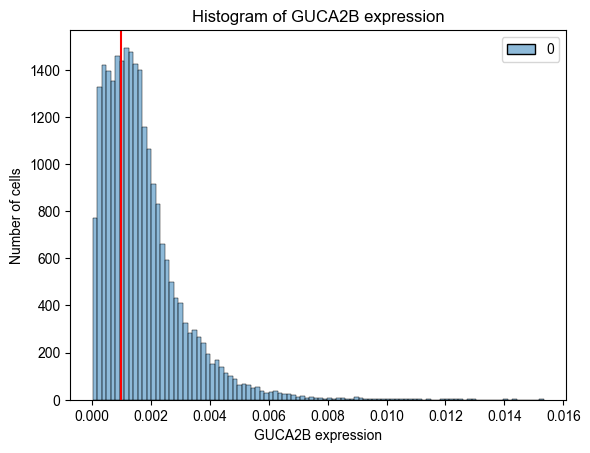

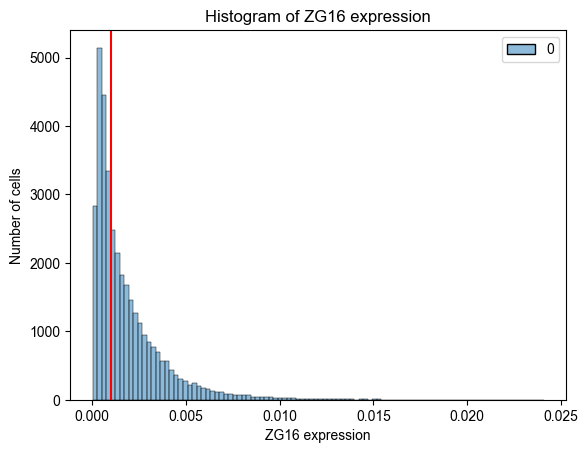

In [7]:
#histogram of AQP8 expression
for key in genes_cutoffs.keys():
    gene_thresh = genes_cutoffs[key][0]
    sns.histplot(adata[adata[:,key].layers["mat_norm"] > 0,key].layers["mat_norm"].todense(), bins=100)
    plt.xlabel(key+" expression")
    plt.ylabel("Number of cells")
    plt.title("Histogram of "+key+" expression")
    plt.axvline(gene_thresh, color='r')
    plt.show()

In [8]:
print(adata.shape)
adata_inter = adata.copy()
for key in genes_cutoffs.keys():
    gene_thresh = genes_cutoffs[key][0]
    print(key+ " " +str(genes_cutoffs[key]))
    if genes_cutoffs[key][1]:
        adata_inter = adata_inter[adata_inter[:,key].layers["mat_norm"].todense().flatten() > gene_thresh].copy()
    else:
        adata_inter = adata_inter[adata_inter[:,key].layers["mat_norm"].todense().flatten() < gene_thresh].copy()
print(adata_inter.shape)
level3_annotation_to_remove = ['Goblet','BEST4_enterocyte_colonocyte',"Tuft","Enteroendocrine","TA"]

adata_inter = adata_inter[~adata_inter.obs.level_3_annot.isin(level3_annotation_to_remove)].copy()
print(adata_inter.shape)

(102822, 18442)
AQP8 (0.001, True)
GUCA2B (0.001, True)
ZG16 (0.001, False)
(9306, 18442)
(8771, 18442)


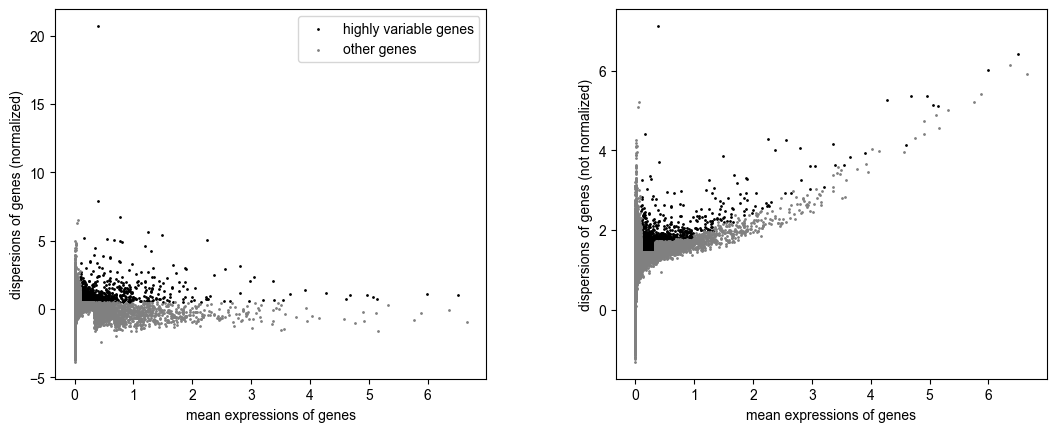

In [9]:
adata_inter.X = adata_inter.layers['counts']
adata_inter.layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(adata_inter, target_sum=10000, inplace=False)['X'], copy=True)
sc.pp.highly_variable_genes(adata_inter, layer='log_norm', min_mean=0.095, max_mean=10, min_disp=0.5)
sc.pl.highly_variable_genes(adata_inter)
adata_inter.layers['log_zscore'] = adata_inter.layers['log_norm']
sc.pp.scale(adata_inter, layer='log_zscore', max_value=10)

In [10]:
sc.pp.neighbors(adata_inter, n_neighbors=10, n_pcs=10, random_state=1) # Number of neighbors can have a considerable effect on how the umap looks. Number of PCs - needs to be high enough.
sc.tl.umap(adata_inter, random_state=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/talbarka/miniconda3/envs/bilomics_env/lib/python

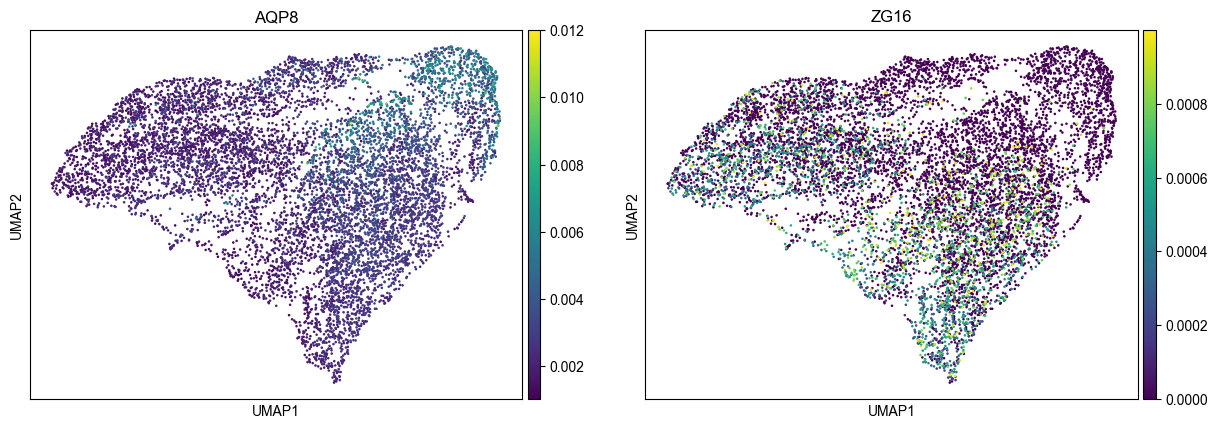

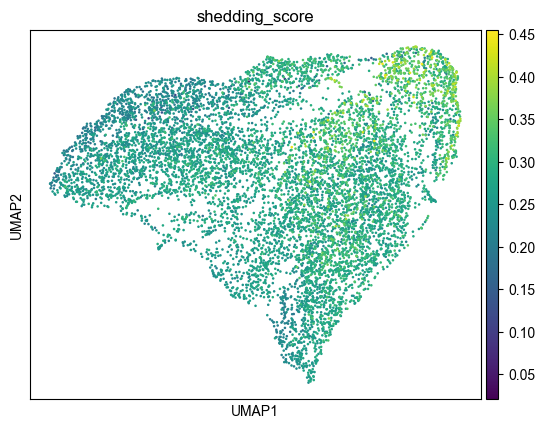

In [11]:
sc.pl.umap(adata_inter,color=["AQP8","ZG16"],layer="mat_norm")
sc.pl.umap(adata_inter,color=["shedding_score"],layer="mat_norm")

/mnt/x/Common/Lab_Papers/shedding_potential/utils/shed_funcs.py:253: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dge_intercrypt.obs['shedding_score_cat'] = 'intermediate'


shedding_score_cat
low     2895
high    2895
Name: count, dtype: int64


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/x/Common/Lab_Papers/shedding_potential/utils/shed_funcs.py:331: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a n

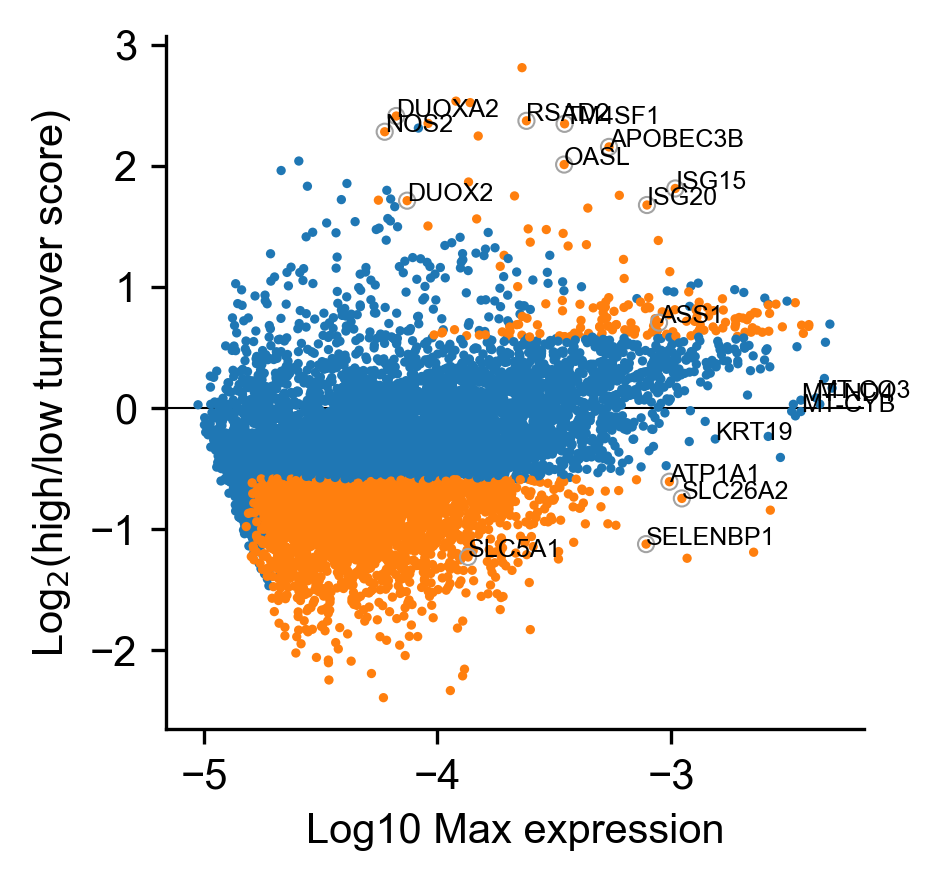

In [12]:
SHEDDING_EDGE = 33
EXP_THRESH = 1e-5
PN = 5e-6
Q_THRESH = 0.05
FC_THRESH = 1.5
USE_ADJUST_TEXT = False

df = shed_funcs.dge_high_low_shed(adata_inter, SHEDDING_EDGE=SHEDDING_EDGE, EXP_THRESH=EXP_THRESH,PN=PN, Q_THRESH=Q_THRESH, FC_THRESH=FC_THRESH)
ma_fig = shed_funcs.ma_plot_shedding(df, additional_N_genes = 5, add_genes = ["ASS1","NOS2","DUOXA2","DUOX2","RSAD2","SELENBP1","ATP1A1","SLC5A1"], font_size=6)

In [13]:
df.to_csv(fig_path+"HGCA_dge_high_low_shed.csv")

In [14]:
ma_fig.savefig(fig_path + "fig5a_highVSlow_shedding.pdf", )

In [15]:
px.scatter(df, x='log10_max', y='log2fc', color='significant', hover_name='gene_name', hover_data=['pvals_adj'])

In [16]:
df

gene_name    m_high     m_low  log10_max    log2fc         pvals  \
feature_name                                                                    
ISG15            ISG15  0.001042  0.000293  -2.981985  1.811648  1.691684e-44   
TM4SF1          TM4SF1  0.000350  0.000065  -3.455843  2.345242  3.102142e-32   
ISG20            ISG20  0.000789  0.000244  -3.103103  1.675111  8.502699e-32   
APOBEC3B      APOBEC3B  0.000542  0.000118  -3.265614  2.154695  1.336699e-28   
OASL              OASL  0.000349  0.000083  -3.457732  2.009153  6.704788e-20   
...                ...       ...       ...        ...       ...           ...   
MT-ND4          MT-ND4  0.003594  0.003437  -2.444371  0.064334  0.000000e+00   
KRT19            KRT19  0.001293  0.001546  -2.810780 -0.256540  0.000000e+00   
MT-CYB          MT-CYB  0.003522  0.003595  -2.444254 -0.029817  0.000000e+00   
SLC26A2        SLC26A2  0.000661  0.001112  -2.953709 -0.746819  0.000000e+00   
MT-CO3          MT-CO3  0.004183  0.003950  -2.378516  0.082541  0.000000e+00   

                 pvals_adj      score      nlogq  significant  
feature_name                                                   
ISG15         1.617157e-43  13.994181  42.791248         True  
TM4SF1        2.044362e-31  11.819312  30.689442         True  
ISG20         5.522417e-31  11.734300  30.257871         True  
APOBEC3B      7.805584e-28  11.094322  27.107595         True  
OASL          2.867367e-19   9.132318  18.542517         True  
...                    ...        ...        ...          ...  
MT-ND4        0.000000e+00 -40.267532        inf        False  
KRT19         0.000000e+00 -40.925434        inf        False  
MT-CYB        0.000000e+00 -41.247597        inf        False  
SLC26A2       0.000000e+00 -41.526630        inf         True  
MT-CO3        0.000000e+00 -41.632195        inf        False  

[7638 rows x 10 columns]

In [17]:
N = 5
top_genes = df.head(N).index
bottom_genes = df.tail(N).index
# craete joint list
joint_genes = list(np.union1d(top_genes, bottom_genes))
joint_genes.extend(['TM4SF1',"ISG15","DUOXA2","NOS2","ASS1"])

2025-02-12 18:46:12,129 [WARNING] Duplicated values found in preranked stats: 0.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Q-value thresh: 0.05


/mnt/x/Common/Lab_Papers/shedding_potential/utils/plot_gsea.py:73: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



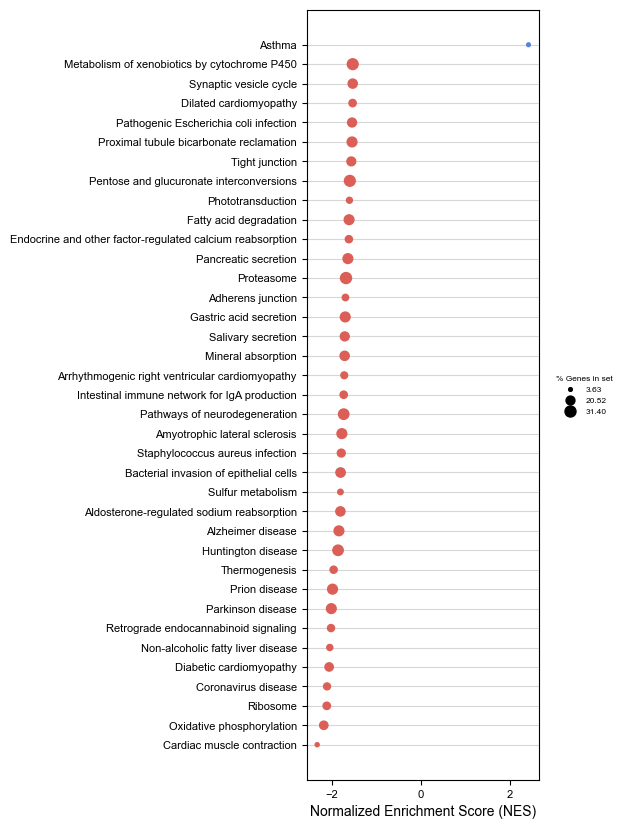

In [18]:
import gseapy as gp
import plot_gsea

Q_THRESH = 0.05
prerank_df = df[['gene_name','score']]
prerank_df.set_index('gene_name', inplace=True)
prerank_df.index = prerank_df.index.str.upper()

selected_gene_set = "KEGG_2021_Human" # MSigDB_Hallmark_2020
pre_res = gp.prerank(rnk = prerank_df,
                     gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                     permutation_num=1000, outdir=None, seed=6,verbose=False)

importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < Q_THRESH:
    [_, fig] = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=Q_THRESH, fig_size=(3,10), return_figure=True)
    fig.savefig(fig_path + "figS3a_GSEA_PanGI_intercrypt.pdf")
else:
    print("No significant gene sets")

In [19]:
SCATTER_POINT_SIZE = 5
FONT_SIZE = 8
my_edge_color = "#a3a3a3"

In [20]:
df[df.gene_name.isin(joint_genes)]

gene_name    m_high     m_low  log10_max    log2fc         pvals  \
feature_name                                                                    
ISG15            ISG15  0.001042  0.000293  -2.981985  1.811648  1.691684e-44   
TM4SF1          TM4SF1  0.000350  0.000065  -3.455843  2.345242  3.102142e-32   
ISG20            ISG20  0.000789  0.000244  -3.103103  1.675111  8.502699e-32   
APOBEC3B      APOBEC3B  0.000542  0.000118  -3.265614  2.154695  1.336699e-28   
OASL              OASL  0.000349  0.000083  -3.457732  2.009153  6.704788e-20   
DUOXA2          DUOXA2  0.000067  0.000008  -4.176682  2.409750  1.092837e-03   
NOS2              NOS2  0.000059  0.000008  -4.226006  2.279887  3.909748e-03   
ASS1              ASS1  0.000888  0.000543  -3.051558  0.704641  4.211906e-11   
MT-ND4          MT-ND4  0.003594  0.003437  -2.444371  0.064334  0.000000e+00   
KRT19            KRT19  0.001293  0.001546  -2.810780 -0.256540  0.000000e+00   
MT-CYB          MT-CYB  0.003522  0.003595  -2.444254 -0.029817  0.000000e+00   
SLC26A2        SLC26A2  0.000661  0.001112  -2.953709 -0.746819  0.000000e+00   
MT-CO3          MT-CO3  0.004183  0.003950  -2.378516  0.082541  0.000000e+00   

                 pvals_adj      score      nlogq  significant  
feature_name                                                   
ISG15         1.617157e-43  13.994181  42.791248         True  
TM4SF1        2.044362e-31  11.819312  30.689442         True  
ISG20         5.522417e-31  11.734300  30.257871         True  
APOBEC3B      7.805584e-28  11.094322  27.107595         True  
OASL          2.867367e-19   9.132318  18.542517         True  
DUOXA2        1.636363e-03   3.265467   2.786120         True  
NOS2          5.404028e-03   2.885353   2.267282         True  
ASS1          1.159716e-10  -6.596425   9.935648         True  
MT-ND4        0.000000e+00 -40.267532        inf        False  
KRT19         0.000000e+00 -40.925434        inf        False  
MT-CYB        0.000000e+00 -41.247597        inf        False  
SLC26A2       0.000000e+00 -41.526630        inf         True  
MT-CO3        0.000000e+00 -41.632195        inf        False

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



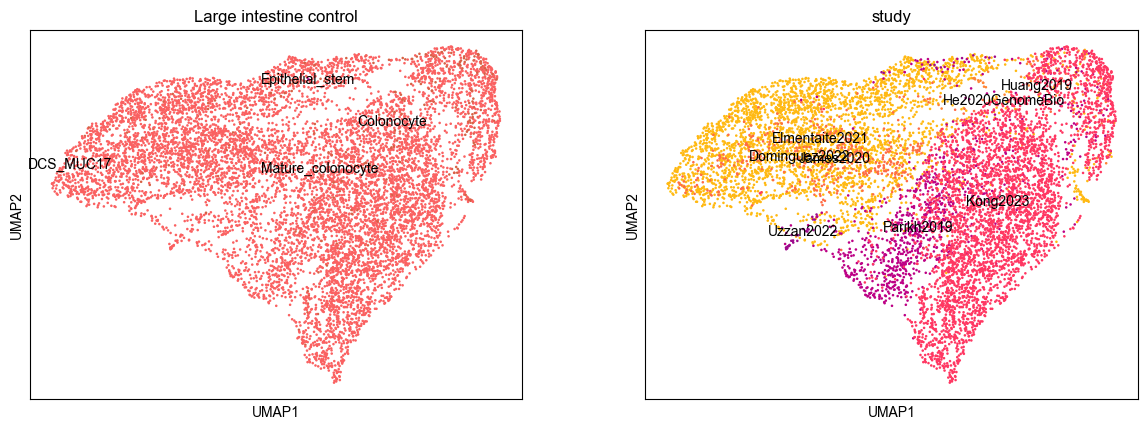

In [21]:
sc.pl.umap(adata_inter,color=["level_3_annot",'study'],legend_loc="on data",title="Large intestine control")

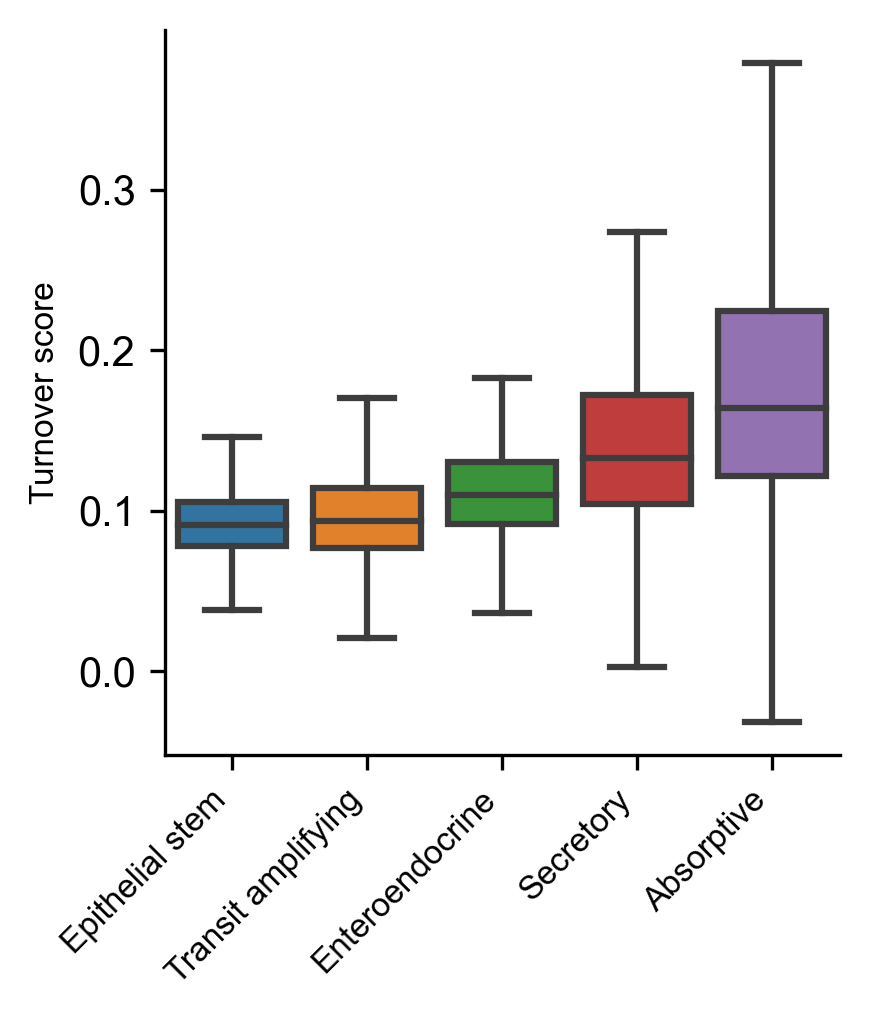

In [22]:
for field in ["level_2_annot"]:
# field = "level_2_annot"
    cell_types = adata.obs[field].unique()
    cell_types_median = adata.obs.groupby(field)['shedding_score'].median().copy()
    cell_types_ord = cell_types_median.sort_values().index.tolist()

    fig,ax, = plt.subplots(figsize=(3,3.5), dpi=300)
    sns.boxplot(data=adata.obs, x=field, y='shedding_score', order=cell_types_ord, showfliers=False, palette="tab10", ax=ax)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel("Turnover score")
    ax.set_xticklabels([label.replace('_', ' ') for label in cell_types_ord], rotation=45, ha='right', fontsize=8)
    # ax.set_xlabel("Healthy colon cell types")
    ax.set_xlabel('')
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    plt.tight_layout()
    plt.show()
    # fig.savefig(fig_path+"Fig4b"+field+".pdf", bbox_inches='tight')

In [23]:
print(datetime.now())

2025-02-12 18:46:28.108787
